<a href="https://colab.research.google.com/github/rajatc2/Machine-Learning/blob/main/Pets-Classification/Pets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Classification

# 0. Prepare Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [ ]:
# Mount and define data dir
from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/"
save_dir = "/content/drive/My Drive/CS441/hw3"

Mounted at /content/drive


In [ ]:
def load_pet_dataset(train_transform = None, test_transform = None):
    OxfordIIITPet = datasets.OxfordIIITPet
    if os.path.isdir(datadir+ "oxford-iiit-pet"):
      do_download = False
    else:
      do_download = True
    training_set = OxfordIIITPet(root = datadir,
                             split = 'trainval',
                             transform = train_transform,
                             download = do_download)

    test_set = OxfordIIITPet(root = datadir,
                           split = 'test',
                           transform = test_transform,
                           download = do_download)
    return training_set, test_set

train_set, test_set = load_pet_dataset()

# Display a sample in OxfordIIIPet dataset
sample_idx = 19 # Choose an image index that you want to display
print("Label:", train_set.classes[train_set[sample_idx][1]])
#train_set[sample_idx][19]

100%|██████████| 791918971/791918971 [00:31<00:00, 24869065.22it/s]


Extracting /content/oxford-iiit-pet/images.tar.gz to /content/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10611063.63it/s]


Extracting /content/oxford-iiit-pet/annotations.tar.gz to /content/oxford-iiit-pet
Label: Abyssinian


## 0a. Data Preprocess using Augmentaion

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Feel free to add augmentation choices

# Apply data augmentation
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [ ]:
# Feel free to change
train_set, test_set = load_pet_dataset(train_transform, test_transform)
train_loader = DataLoader(dataset=train_set,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_set,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)


## 0b. Helper Functions

In [ ]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

In [ ]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

# 1. Fine-Tune Pre-trained Network (ResNet) on Pets

In [ ]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images)
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

Loading pretrained ResNET-34 model and display model

In [ ]:
device = 'cuda'
# loads a pre-trained ResNet-34 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
target_class = 37
# TO DO: replace the last layer with a new linear layer for Pets classification
feature_no = model.fc.in_features
model.fc = nn.Linear(feature_no, target_class)

model = model.to(device)
display_model(model) # displays the model structure and parameter count

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 52.9MB/s]


- conv1                                    :                9408               
- bn1                                      :                128                
- relu                                     :                 0                 
- maxpool                                  :                 0                 
- layer1                                   :               221952              
- layer2                                   :              1116416              
- layer3                                   :              6822400              
- layer4                                   :              13114368             
- avgpool                                  :                 0                 
- fc                                       :               18981               
--Total                                    :          21303653 params          --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(6

In [ ]:
# Training Setting. Feel free to change.
num_epochs = 20
test_interval = 5

# TO DO: set initial learning rate
learn_rate = 0.000095
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# TO DO: define your learning rate scheduler, e.g. StepLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5, last_epoch=- 1)

criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []


# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    lr_scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
          print("Saving Model")
          save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance



loss: 1.035: 100%|██████████| 58/58 [00:47<00:00,  1.23it/s]


Loss for Training on epoch 0 is 2.080167770385742 

Evaluating Network


Validating ...: 100%|██████████| 58/58 [00:45<00:00,  1.28it/s]

Mean Accuracy: 0.7943
Avg loss: 0.8979830238325842
Training accuracy on epoch 0 is 0.7942934782608696 




Validating ...: 100%|██████████| 58/58 [00:24<00:00,  2.39it/s]


Mean Accuracy: 0.8291
Avg loss: 0.7638984045078014
Testing accuracy on epoch 0 is 0.8291087489779232 

Saving Model



loss: 0.610: 100%|██████████| 58/58 [00:45<00:00,  1.29it/s]

Loss for Training on epoch 1 is 0.7559243440628052 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]

Mean Accuracy: 0.8918
Avg loss: 0.4561938052547389
Training accuracy on epoch 1 is 0.8918478260869566 




Validating ...: 100%|██████████| 58/58 [00:22<00:00,  2.58it/s]


Mean Accuracy: 0.8741
Avg loss: 0.4845520658739682
Testing accuracy on epoch 1 is 0.8740801308258381 

Saving Model



loss: 0.437: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s]

Training ...:  15%|█▌        | 3/20 [04:40<23:47, 83.95s/it] 

Loss for Training on epoch 2 is 0.4809901714324951 



loss: 0.251: 100%|██████████| 58/58 [00:45<00:00,  1.28it/s]

Training ...:  20%|██        | 4/20 [05:26<18:19, 68.70s/it]

Loss for Training on epoch 3 is 0.3238767981529236 



loss: 0.300: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]

Training ...:  25%|██▌       | 5/20 [06:10<14:59, 59.94s/it]

Loss for Training on epoch 4 is 0.2649219036102295 



loss: 0.191: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s]

Loss for Training on epoch 5 is 0.2206096649169922 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]

Mean Accuracy: 0.9617
Avg loss: 0.1492152746509889
Training accuracy on epoch 5 is 0.9616847826086956 




Validating ...: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


Mean Accuracy: 0.8989
Avg loss: 0.36873087267680416
Testing accuracy on epoch 5 is 0.8988825292995366 

Saving Model



loss: 0.170: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s]

Training ...:  35%|███▌      | 7/20 [08:45<14:24, 66.47s/it]

Loss for Training on epoch 6 is 0.18318110704421997 



loss: 0.324: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s]

Training ...:  40%|████      | 8/20 [09:30<11:55, 59.62s/it]

Loss for Training on epoch 7 is 0.1545996516942978 



loss: 0.161: 100%|██████████| 58/58 [00:45<00:00,  1.29it/s]

Training ...:  45%|████▌     | 9/20 [10:15<10:06, 55.10s/it]

Loss for Training on epoch 8 is 0.13294096291065216 



loss: 0.096: 100%|██████████| 58/58 [00:45<00:00,  1.29it/s]

Training ...:  50%|█████     | 10/20 [11:00<08:40, 52.05s/it]

Loss for Training on epoch 9 is 0.11384832859039307 



loss: 0.063: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s]

Loss for Training on epoch 10 is 0.10987219214439392 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s]

Mean Accuracy: 0.9886
Avg loss: 0.06899316140033047
Training accuracy on epoch 10 is 0.9885869565217391 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.80it/s]


Mean Accuracy: 0.8992
Avg loss: 0.3532118036829192
Testing accuracy on epoch 10 is 0.899155083128918 

Saving Model



loss: 0.079: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]

Training ...:  60%|██████    | 12/20 [13:39<08:28, 63.58s/it]

Loss for Training on epoch 11 is 0.09746094048023224 



loss: 0.117: 100%|██████████| 58/58 [00:52<00:00,  1.11it/s]

Training ...:  65%|██████▌   | 13/20 [14:31<07:00, 60.14s/it]

Loss for Training on epoch 12 is 0.09284461289644241 



loss: 0.158: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s]

Training ...:  70%|███████   | 14/20 [15:15<05:31, 55.32s/it]

Loss for Training on epoch 13 is 0.09609602391719818 



loss: 0.073: 100%|██████████| 58/58 [00:45<00:00,  1.27it/s]

Training ...:  75%|███████▌  | 15/20 [16:01<04:22, 52.46s/it]

Loss for Training on epoch 14 is 0.08614178001880646 



loss: 0.044: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s]

Loss for Training on epoch 15 is 0.09160148352384567 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]

Mean Accuracy: 0.9908
Avg loss: 0.05611177453578546
Training accuracy on epoch 15 is 0.9907608695652174 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.83it/s]


Mean Accuracy: 0.8997
Avg loss: 0.3465219064904698
Testing accuracy on epoch 15 is 0.8997001907876806 

Saving Model



loss: 0.072: 100%|██████████| 58/58 [00:44<00:00,  1.30it/s]

Training ...:  85%|████████▌ | 17/20 [18:33<03:04, 61.55s/it]

Loss for Training on epoch 16 is 0.08497121185064316 



loss: 0.106: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]

Training ...:  90%|█████████ | 18/20 [19:17<01:52, 56.42s/it]

Loss for Training on epoch 17 is 0.076754130423069 



loss: 0.121: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s]

Training ...:  95%|█████████▌| 19/20 [20:01<00:52, 52.66s/it]

Loss for Training on epoch 18 is 0.08469779044389725 



loss: 0.096: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]

Loss for Training on epoch 19 is 0.07772348821163177 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]

Mean Accuracy: 0.9935
Avg loss: 0.05023674300775446
Training accuracy on epoch 19 is 0.9934782608695653 




Validating ...: 100%|██████████| 58/58 [00:22<00:00,  2.61it/s]


Mean Accuracy: 0.9016
Avg loss: 0.34127141638048764
Testing accuracy on epoch 19 is 0.9016080675933497 

Saving Model



Training ...: 100%|██████████| 20/20 [21:50<00:00, 65.51s/it]


Plotting losses and accuracy

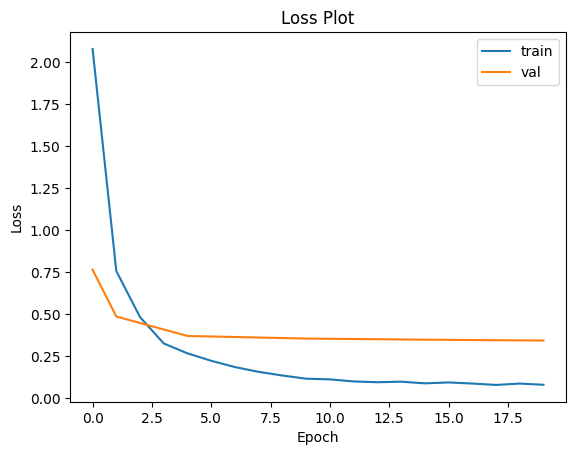

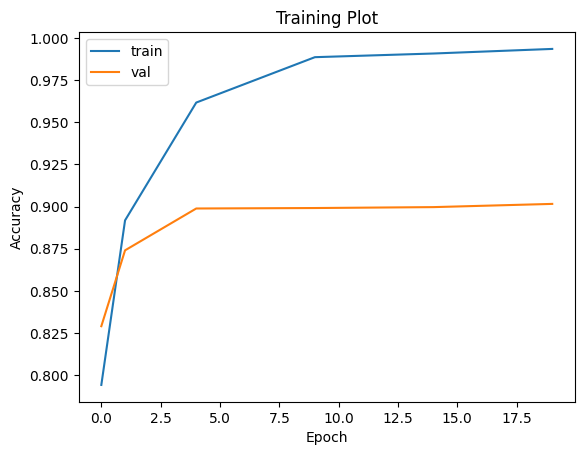

In [ ]:
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

Evaluating trained model

In [ ]:
# TO DO: initialize your trained model as you did before so that you can load the parameters into it
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True).to(device)
# replace last layer
feature_no = model.fc.in_features
model.fc = nn.Linear(feature_no, target_class)
model = model.to(device)

load_model(model, save_dir) # Load the trained weight

test_accuracy, test_loss= test(test_loader, model, criterion)
print(f"Testing accuracy is {str(test_accuracy)} \n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
<ipython-input-11-bbcbe49c7d9f>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Mean Accuracy: 0.9016
Avg loss: 0.34127141638048764
Testing accuracy is 0.9016080675933497 



# 2. Building own network from scratch

In [ ]:
# example network definition that needs to be modified for custom network stretch goal

class Network(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.5):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )


    def forward(self, x):
        N, c, H, W = x.shape
        features = self.features(x)
        pooled_features = self.avgpool(features)
        output = self.classifier(torch.flatten(pooled_features, 1))
        return output

In [ ]:
##RESNET
import torch.nn as nn; import torch.nn.functional as nnf; import torch
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.dropout = nn.Dropout(p=0.12)

    def forward(self, x):
        residual = x
        out = nnf.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = nnf.relu(out)
        out = self.dropout(out) # Apply dropout to the output
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=37):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(ResBlock(64, 64),ResBlock(64, 64))
        self.layer2 = nn.Sequential(ResBlock(64, 128, stride=2),  ResBlock(128, 128))
        self.layer3 = nn.Sequential(ResBlock(128, 256, stride=2), ResBlock(256, 256))
        #self.layer4 = nn.Sequential(ResBlock(256, 512, stride=2), ResBlock(512, 512))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x);
        x = self.bn1(x);
        x = nnf.relu(x);
        x = self.maxpool(x)
        x = self.layer1(x);
        x = self.layer2(x);
        x = self.layer3(x);  #x = self.layer4(x);
        x = self.avgpool(x);
        x = torch.flatten(x, 1);  x = self.fc(x)
        return x

model = ResNet(num_classes=37)
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = model.to(device)

display_model(model)

- conv1                                    :                9408               
- bn1                                      :                128                
- maxpool                                  :                 0                 
- layer1                                   :               147968              
- layer2                                   :               525568              
- layer3                                   :              2099712              
- avgpool                                  :                 0                 
- fc                                       :                9509               
--Total                                    :           2792293 params          --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (la

In [ ]:
learn_rate = 0.0098; num_epochs = 60 ;     test_interval = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

train_losses = [];
train_accuracy_list = [];
test_losses = [];
test_accuracy_list = []

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    lr_scheduler.step() ;    train_losses.append(train_loss)

    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)
        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss);        test_accuracy_list.append(test_accuracy)
        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
#           print("Saving Model")
          save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance


Validating ...: 100%|██████████| 58/58 [00:40<00:00,  1.45it/s]

Mean Accuracy: 0.0416
Avg loss: 3.62731802052465
Training accuracy on epoch 0 is 0.04157608695652174 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]


Mean Accuracy: 0.0379
Avg loss: 3.638671640692086
Testing accuracy on epoch 0 is 0.03788498228400109 




Validating ...: 100%|██████████| 58/58 [00:39<00:00,  1.45it/s]

Mean Accuracy: 0.0592
Avg loss: 3.7936663134344695
Training accuracy on epoch 1 is 0.05923913043478261 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  3.02it/s]

Training ...:   3%|▎         | 2/60 [03:23<1:38:06, 101.49s/it]

Mean Accuracy: 0.0491
Avg loss: 3.790154785945498
Testing accuracy on epoch 1 is 0.04905968928863451 



loss: 3.502: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 3.331: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]

loss: 3.377: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 3.392: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

loss: 2.966: 100%|██████████| 58/58 [00:40<00:00,  1.45it/s]

loss: 3.240: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]

loss: 3.552: 100%|██████████| 58/58 [00:40<00:00,  1.41it/s]

loss: 3.294: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

Validating ...: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]

Mean Accuracy: 0.1269
Avg loss: 3.1011577228019975
Training accuracy on epoch 10 is 0.12690217391304348 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.80it/s]

Training ...:  18%|█▊        | 11/60 [10:30<49:17, 60.36s/it]

Mean Accuracy: 0.1292
Avg loss: 3.095428158496988
Testing accuracy on epoch 10 is 0.12919051512673754 



loss: 3.079: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

loss: 2.880: 100%|██████████| 58/58 [00:40<00:00,  1.44it/s]

loss: 2.800: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]

loss: 3.314: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 3.067: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 2.937: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]

loss: 2.384: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]

loss: 2.835: 100%|██████████| 58/58 [00:40<00:00,  1.41it/s]

loss: 2.988: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]

Validating ...: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]

Mean Accuracy: 0.2793
Avg loss: 2.565370428151098
Training accuracy on epoch 20 is 0.2793478260869565 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  3.00it/s]

Training ...:  35%|███▌      | 21/60 [18:19<38:35, 59.37s/it]

Mean Accuracy: 0.2398
Avg loss: 2.696735217653472
Testing accuracy on epoch 20 is 0.23984736985554647 



loss: 2.398: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]

loss: 2.964: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s]

loss: 2.335: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 2.342: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

loss: 2.591: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]

loss: 2.208: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]

loss: 2.721: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]

loss: 2.464: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]

loss: 2.260: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

Validating ...: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]

Mean Accuracy: 0.3883
Avg loss: 2.131317068790567
Training accuracy on epoch 30 is 0.38831521739130437 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.74it/s]

Training ...:  52%|█████▏    | 31/60 [26:13<28:55, 59.85s/it]

Mean Accuracy: 0.3085
Avg loss: 2.419024607230877
Testing accuracy on epoch 30 is 0.3085309348596348 



loss: 2.246: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s]

loss: 2.042: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

loss: 2.010: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]

loss: 2.330: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 1.851: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

loss: 1.723: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s]

loss: 1.876: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 2.021: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s]

loss: 1.903: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

Validating ...: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]

Mean Accuracy: 0.4826
Avg loss: 1.7335741149968114
Training accuracy on epoch 40 is 0.4826086956521739 




Validating ...: 100%|██████████| 58/58 [00:21<00:00,  2.69it/s]

Training ...:  68%|██████▊   | 41/60 [34:15<19:27, 61.44s/it]

Mean Accuracy: 0.3827
Avg loss: 2.151932149097837
Testing accuracy on epoch 40 is 0.38266557645134913 



loss: 2.133: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s]

loss: 2.015: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]

loss: 1.568: 100%|██████████| 58/58 [00:43<00:00,  1.32it/s]

loss: 2.283: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]

loss: 2.129: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]

loss: 1.768: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]

loss: 1.747: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 1.777: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]

loss: 1.336: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]

Validating ...: 100%|██████████| 58/58 [00:41<00:00,  1.38it/s]

Mean Accuracy: 0.5190
Avg loss: 1.6202128324015388
Training accuracy on epoch 50 is 0.5190217391304348 




Validating ...: 100%|██████████| 58/58 [00:19<00:00,  2.91it/s]

Training ...:  85%|████████▌ | 51/60 [42:26<09:17, 61.99s/it]

Mean Accuracy: 0.3895
Avg loss: 2.122638673617922
Testing accuracy on epoch 50 is 0.3894794221858817 



loss: 1.495: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s]

loss: 2.016: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]

loss: 1.717: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 1.690: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]

loss: 1.883: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 1.456: 100%|██████████| 58/58 [00:42<00:00,  1.37it/s]

loss: 1.441: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]

loss: 1.734: 100%|██████████| 58/58 [00:40<00:00,  1.44it/s]

Validating ...: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

Mean Accuracy: 0.5380
Avg loss: 1.5643995609776726
Training accuracy on epoch 59 is 0.5380434782608695 




Validating ...: 100%|██████████| 58/58 [00:20<00:00,  2.85it/s]

Training ...: 100%|██████████| 60/60 [49:49<00:00, 49.82s/it]

Mean Accuracy: 0.3919
Avg loss: 2.1013697180254707
Testing accuracy on epoch 59 is 0.3919324066503134 



In [ ]:
print(test_accuracy_list)

[0.03788498228400109, 0.04905968928863451, 0.12919051512673754, 0.23984736985554647, 0.3085309348596348, 0.38266557645134913, 0.3894794221858817, 0.3919324066503134]
